In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras import layers, models
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [10]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [11]:
# 1d convnet work
X = train_df.iloc[:, :-2].values
y = train_df['Activity'].values

X_test= test_df.iloc[:, :-2].values
y_test = test_df['Activity'].values

# Normalize the feature vectors
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.fit_transform(y_test)

# (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert labels to one-hot encoded numbers
y = to_categorical(y)
y_test = to_categorical(y_test)

In [12]:
# 2d convnet work
X2d = train_df.iloc[:, :-2].values
y2d = train_df['Activity'].values

X2d_test= test_df.iloc[:, :-2].values
y2d_test = test_df['Activity'].values

# Normalize the feature vectors
scaler = StandardScaler()
X2d = scaler.fit_transform(X2d)
X2d_test = scaler.fit_transform(X2d_test)

label_encoder = LabelEncoder()
y2d = label_encoder.fit_transform(y2d)
y2d_test = label_encoder.fit_transform(y2d_test)

# (samples, timesteps, features). 3d data
X2d = X2d.reshape(X2d.shape[0], X2d.shape[1], 1, 1)
X2d_test = X2d_test.reshape(X2d_test.shape[0], X2d_test.shape[1], 1, 1)

# Convert labels to one-hot encoded numbers
y2d = to_categorical(y2d)
y2d_test = to_categorical(y2d_test)


In [13]:
def makeModel1d():
    model = models.Sequential()
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Modified makeModel2d with dropout and batch normalization
def makeModel2d():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 1), activation='relu', input_shape=(X2d.shape[1], X2d.shape[2], 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(64, (3, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(128, (3, 1), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def modelHistory(daModel, epoch, batch):
    daModel.fit(X, y, epochs=epoch, batch_size=batch, validation_split=0.2)

In [14]:
class ModelObject:
    def __init__(self):
        self.epoch = None
        self.model = None
        self.batch = None
        self.accuracy = None
        self.loss = None
        self.modelDimension = None


In [19]:
"""epochs_list = [50, 100, 150]
batch_sizes = [32, 64, 128, 256]"""
epochs_list = [100]
batch_sizes = [128]

# After running overnight the best model is 100 epochs, at 128 batchsize
Best_test_loss = 1
Best_test_accuracy = 0
best_model = ModelObject()
best_model.accuracy = Best_test_accuracy
best_model.loss = Best_test_loss

for epochs in epochs_list:
    for batch_size in batch_sizes:
        model = makeModel1d()
        #model2d = makeModel2d()
        history = modelHistory(model, epochs, batch_size)
        #history2d = modelHistory(model2d, epochs, batch_size)
        test_loss, test_accuracy = model.evaluate(X_test, y_test)
        #test_loss2d, test_accuracy2d = model2d.evaluate(X_test, y_test)

        if (Best_test_accuracy < test_accuracy):
            Best_test_loss = test_loss
            Best_test_accuracy = test_accuracy
            best_model.model = model
            best_model.epoch = epochs
            best_model.modelDimension = 1
            best_model.batch = batch_size
            best_model.loss = Best_test_loss
            best_model.accuracy = Best_test_accuracy

        """if (Best_test_accuracy < test_accuracy2d):
            Best_test_loss = test_loss2d
            Best_test_accuracy = test_accuracy2d
            best_model.model = model2d
            best_model.epoch = epochs
            best_model.modelDimension = 2
            best_model.batch = batch_size
            best_model.loss = Best_test_loss
            best_model.accuracy = Best_test_accuracy"""


print(best_model.batch, best_model.epoch, best_model.accuracy, best_model.modelDimension)

Epoch 1/100
46/46 [==============================] - 5s 76ms/step - loss: 1.4142 - accuracy: 0.5691 - val_loss: 1.5317 - val_accuracy: 0.2148
Epoch 2/100
46/46 [==============================] - 3s 73ms/step - loss: 0.5563 - accuracy: 0.7932 - val_loss: 2.2046 - val_accuracy: 0.2842
Epoch 3/100
46/46 [==============================] - 3s 73ms/step - loss: 0.3464 - accuracy: 0.8762 - val_loss: 2.7687 - val_accuracy: 0.3154
Epoch 4/100
46/46 [==============================] - 3s 73ms/step - loss: 0.2517 - accuracy: 0.9094 - val_loss: 3.2069 - val_accuracy: 0.2005
Epoch 5/100
46/46 [==============================] - 4s 80ms/step - loss: 0.1958 - accuracy: 0.9299 - val_loss: 1.5304 - val_accuracy: 0.4942
Epoch 6/100
46/46 [==============================] - 4s 81ms/step - loss: 0.1590 - accuracy: 0.9435 - val_loss: 0.8019 - val_accuracy: 0.7573
Epoch 7/100
46/46 [==============================] - 4s 82ms/step - loss: 0.1371 - accuracy: 0.9554 - val_loss: 0.4930 - val_accuracy: 0.8518
Epoch 

In [20]:
y_pred_test = best_model.model.predict(X_test)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

# Reduce the dimensionality to 50 components (samples, features) for PCA. Got rid of timesteps and made X 2d
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Apply PCA for dimensionality reduction to 50 components to simplify data.
# I can use just tsne but using PCA first to reduce dimensionality introduces less noise and more consistency
pca = PCA(n_components=50)
x_pca_test = pca.fit_transform(X_test_reshaped)

# Reduce the dimensionality to 2 components to simplify data for scatter plot.
tsne = TSNE(n_components=2, random_state=42)
x_tsne_test = tsne.fit_transform(x_pca_test)

# Get the true labels for the test data
y_test_labels = np.argmax(y_test, axis=1)


93/93 [==============================] - 1s 6ms/step


Wrong 162, Right 2785, Actual accuracy:0.9418312387791742


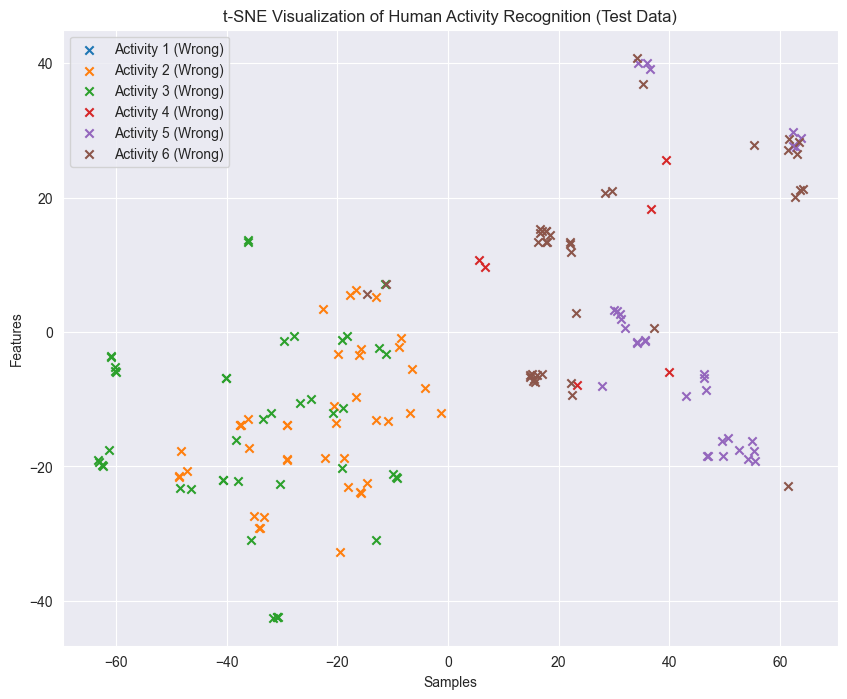

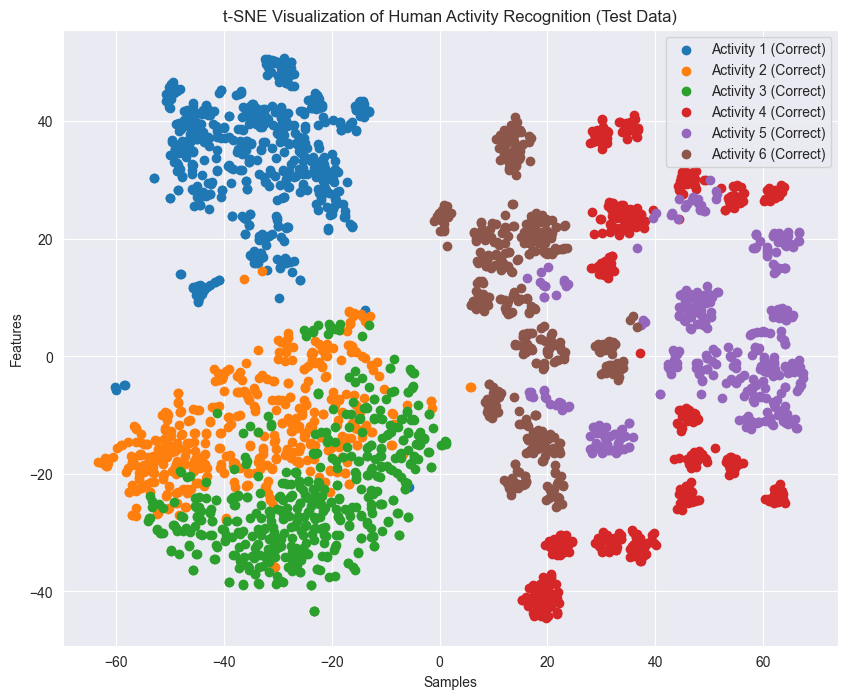

In [21]:
wrong = 0
right = 0
for i in range(len(y_test_labels)):
    if y_test_labels[i] != y_pred_test_labels[i]:
        wrong += 1
    else:
        right += 1

print(f"Wrong {wrong}, Right {right}, Actual accuracy:{1 - (wrong / right)}")

plt.figure(figsize=(10, 8))
for i in range(6):
   # Plot wrongly predicted points from the test data
    plt.scatter(x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels != y_test_labels), 0],
                x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels != y_test_labels), 1],
                label=f"Activity {i+1} (Wrong)", marker='x')

plt.title("t-SNE Visualization of Human Activity Recognition (Test Data)")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Features")
plt.show()


plt.figure(figsize=(10, 8))
for i in range(6):
    # Plot correctly predicted points from the test data
    plt.scatter(x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels == y_test_labels), 0],
                x_tsne_test[(y_pred_test_labels == i) & (y_pred_test_labels == y_test_labels), 1],
                label=f"Activity {i+1} (Correct)", marker='o')

plt.title("t-SNE Visualization of Human Activity Recognition (Test Data)")
plt.legend()
plt.xlabel("Samples")
plt.ylabel("Features")
plt.show()
